In [ ]:
#| default_exp detect_lidar_water_surface

In [ ]:
#| hide
from nbdev.showdoc import *

# Detect water surface.

Most water bodies self level. Lidar elevation measurements of the water surface can frequently be detected by looking at histogram of the elevation measurements.  The water surface will be flat except for any
surface wave action, and even the waves can be accomodated with larger 
histogram bins.  This function eaxmines the lidar elevatoin measurements
and if it detects a flat surface which is above a threshold, it will
return an object with attributes about the surface, including the 
detected water surface mean and median heights, and the standard deviation of those detected heights. It also returns a bool `water_found`.

In [ ]:
#| export
import pandas            as pd 
import haversine         as hs
import numpy             as np
import os
import matplotlib.pyplot as plt
import sys

In [ ]:
import lidar_review_tools.lidar_tools as lt

ModuleNotFoundError: No module named 'lidar_review_tools'

#| hide
### def detect_lidar_water_surface()

In [ ]:
#| export
def detect_lidar_water_surface( 
  df,                                                # DataFrame or Numpy data containing a column of LiDAR elevations.
  col             = 'elev',                          # Label of elevation data. 
  thresh          = 4,                               # Minimum number of elevations required for water surface detection.
  binsize         = 0.1,                             # Elevation binsize in meters.
  plot            = True,                            # Optionally generate plots of the elevation histogram, and inputelevations.
  height          = 4,                               # Height of the plot.
  width           = 10,                              # Width of the plot.
  title           = 'Lidar Water Surface Detector',  # Plot title.
  xlabel          = 'Elevations [m]',                # Plot X axis label.
  ylabel          = 'Range Bin Count',               # Plot Y axis label.
  title_fontsize  = 14,                              # Plot title font size, (points)
  xlabel_fontsize = 12,                              # Plot xlabel font size, (points)
  ylabel_fontsize = 12                               # Plot ylabel font size (points)
  ) -> object:                                       # A class containing attributes.
  """
  Find the water surface in a Pandas dataframe or numpy array.
  """
  class RV:
    pass
  rv = RV()
  rv.water_found = False
  rv.binsize     = binsize
  rv.thresh      = thresh
  rv.plot        = plot
  rv.ele_min     = np.min(df[col])
  rv.ele_max     = np.max(df[col])
  rv.surface_bin_value = None 

  # Compute the elevation difference to make sure it's not crazy
  rv.peak_elevation_dif = rv.ele_max - rv.ele_min

  # Generate the x axis bins
  rv.bins = np.arange(rv.ele_min, rv.ele_max+1.0, 0.1)

  # Compute the histogram.  Any water surface return shoud produce a
  # spike in the histogram
  rv.hist = np.histogram(df[col], bins = rv.bins)

  # Find the bin with the maximum number of hits.
  rv.max_v = np.max( rv.hist[0] )

  # If the hit count exceeds the uesr's threshold, then we probably
  # found the water surface.
  if rv.max_v >= thresh:
    rv.water_found = True
    # rv.surface_idx = np.where( rv.hist[0] >= thresh )[0][0]
    rv.surface_idx = np.where( rv.hist[0] == rv.max_v )[0][0]
    rv.surface_bin_value = rv.hist[1][rv.surface_idx]

    # Compute stats for return on the values within the bin
    a = df[ col ]
    rv.low  = rv.surface_bin_value - rv.binsize
    rv.high = rv.surface_bin_value + rv.binsize
    b = a.where( (a > rv.low) & (a < rv.high) ).dropna()
    rv.mean_surface = np.mean( b )
    rv.std_surface  = np.std( b )
    rv.median_surface = np.median( b )
  
  # If the user wants plots, then generate plots of the results
  if plot and rv.water_found:
    plt.figure( figsize=(width,height) )
  
    # Draw the threshold line
    x = rv.hist[1][0], rv.hist[1][-1]
    y = [thresh, thresh]
    plt.plot(x,y, linestyle=':')

    # Plot the word `Threshold` just above the threshold line.
    plt.text( x[0]+.5, y[0]+.1, "Threshold", fontsize=8)

    # Draw the range bin cont data (histogram results)
    plt.plot(rv.hist[1][:-1], rv.hist[0], color='blue')
    x = rv.hist[1][rv.surface_idx]

    # Draw a marker where the water surface was found. 
    plt.scatter( x, rv.max_v, marker='D',  color='green')

    # Draw the mean height in text by the detected peak.
    plt.text( x+.5, rv.max_v-.1, f"{rv.mean_surface:6.3f}m")

    plt.title(   title, fontsize = title_fontsize  )
    plt.xlabel( xlabel, fontsize = xlabel_fontsize )
    plt.ylabel( ylabel, fontsize = ylabel_fontsize )
    plt.show()

  return rv

# Testing

## Colab
If you are testing this on Google Colab, run this cell to select the ATM data
file for testing.

In [ ]:
if __name__ == '__main__' and True:
  test_atm_fn = '/content/lidar_review_tools/data/atm/profile-1-atm-xyz.zip'

In [ ]:
! head {test_atm_fn}

## Docker Jlab. 
Run this cell if you are running in the Docker Jlab 

In [ ]:
if __name__ == '__main__' and True:
  test_atm_fn = '~/work/github-projects/lidar_review_tools/data/atm/profile-1-atm-xyz.zip'

Now, let's take a quicklook at the first 3 lines of the data in the file.  
It is in classic CSV format.  The first column is `Longitude`, second column
is `Latitude` and the third is the `elevation` data.

In [ ]:
! zcat {test_atm_fn} | head -3

-49.4788530000,69.0319020000,623.736
-49.4788610000,69.0318160000,624.403
-49.4788690000,69.0317280000,623.6


## Load the ATM test data
Now load the test data into a `Pandas` `DataFrame`using the `Pandas` `read_csv()` csv reader.  
Since the data does not already have any column labels, we will add column names
using the `names` parameter, and then via the `read_csv()`
function.

In [ ]:
if __name__ == '__main__' and True:
  atm = pd.read_csv(test_atm_fn, names=["lon", "lat", "elev"])

In [ ]:
atm.head(3)

,lon,lat,elev
0,-49.478853,69.031902,623.736
1,-49.478861,69.031816,624.403
2,-49.478869,69.031728,623.600


<matplotlib.collections.PathCollection>

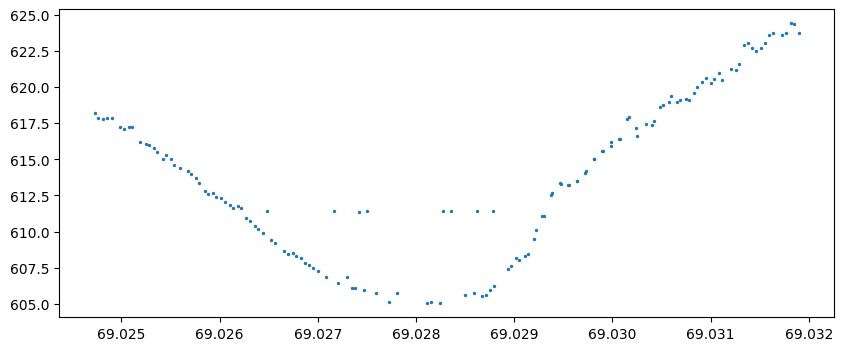

In [ ]:
plt.figure( figsize=(10,4))
plt.scatter( atm['lat'],  atm['elev'], marker='o', s=2 )

Load the ATM test profile dataset, run `detect_lidar_water_surface()`  and plot the results.

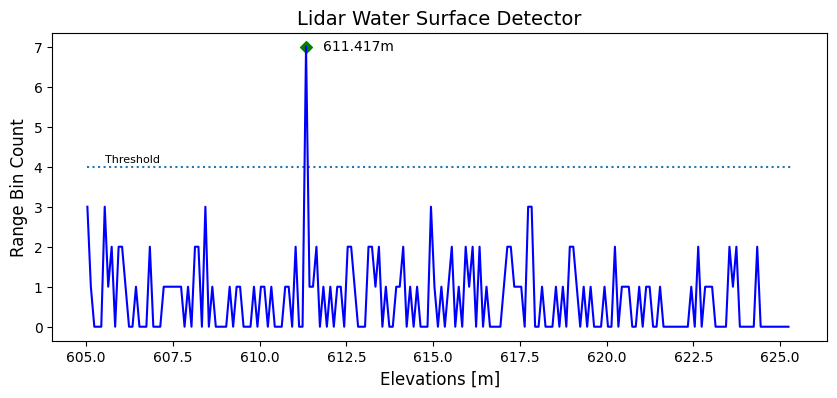

In [ ]:
## Test detect_lidar_water_surface()
if __name__ == '__main__' and True:
  rv = detect_lidar_water_surface(atm, plot=True, thresh=4, binsize = 0.1 )

## Printout the return `rv` data.

In [ ]:
if __name__ == '__main__' and True:
  print("\nData returned by detect_lidar_water_surface()\n\n Key                 : Value\n-------------------------------")
  for i in rv.__dict__:
    if i == 'bins' or i == 'hist':
      continue
    if type( rv.__dict__[i] ) == np.float64:
      print(f"{i:20}: {rv.__dict__[i]:8.3f}")
    else:
      print(f'{i:20}: {rv.__dict__[i]}')


Data returned by detect_lidar_water_surface()

 Key                 : Value
-------------------------------
water_found         : True
binsize             : 0.1
thresh              : 4
plot                : True
ele_min             :  605.037
ele_max             :  624.403
surface_bin_value   :  611.337
peak_elevation_dif  :   19.366
max_v               : 7
surface_idx         : 63
low                 :  611.237
high                :  611.437
mean_surface        :  611.417
std_surface         :    0.015
median_surface      :  611.421


Text(69.024727, 611.6167142857144, 'Water Surface')

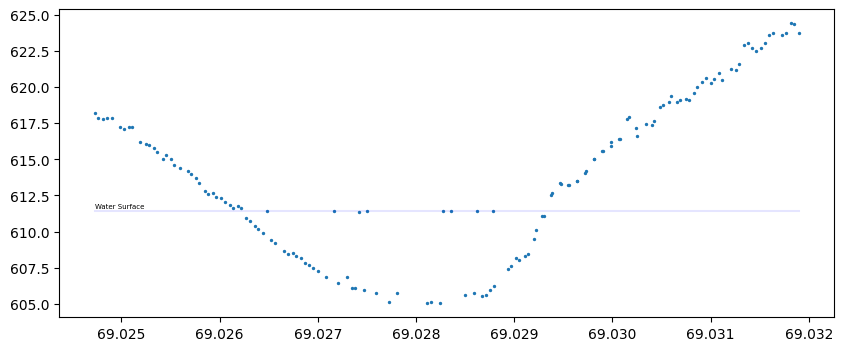

In [ ]:
x = [atm['lat'].min(), atm['lat'].max()]
y = [rv.mean_surface,rv.mean_surface]
plt.figure( figsize=(10,4)) 
plt.plot( x, y, color='blue', alpha=.1)
plt.scatter(atm['lat'], atm['elev'], marker='o', s=2 )
plt.text( x[0], y[0]+.2, "Water Surface", fontsize=5)

In [ ]:
x

[69.024727, 69.031902]